[Mountain View Spatiotemporal Analysis Working Group](http://www.meetup.com/Mountain-View-Spatiotemporal-Analysis-Working-Group/)

# Load dataset

In [1]:
import os
import pandas

source_folder = os.path.expanduser('~/Datasets/USA/Seattle')
source_path = os.path.join(source_folder, 'Seattle-FireDepartmentResponses-20140203.h5')
seattle_fire_responses = pandas.read_hdf(source_path, 'raw')
seattle_fire_response_locations = seattle_fire_responses[
    ['Longitude', 'Latitude']].values
seattle_fire_responses[:2]

,Address,Type,Datetime,Latitude,Longitude,Incident Number
0,4th Av N / Mercer St,Aid Response,2014-02-03 23:56:00,47.624564,-122.348877,F140012355
1,2121 8th Av,Aid Response,2014-02-03 23:47:00,47.616647,-122.338160,F140012352


In [2]:
from geometryIO import get_transformPoint, proj4LL

# http://spatialreference.org/ref/epsg/2855/
proj4_washington_north = (
    '+proj=lcc +lat_1=48.73333333333333 +lat_2=47.5 +lat_0=47 '
    '+lon_0=-120.8333333333333 +x_0=500000 +y_0=0 +ellps=GRS80 +units=m +no_defs ')
transform_point = get_transformPoint(proj4LL, proj4_washington_north)
untransform_point = get_transformPoint(proj4_washington_north, proj4LL)
print tuple(seattle_fire_response_locations[0])
print untransform_point(*transform_point(*seattle_fire_response_locations[0]))

(-122.348877, 47.624563999999999)
(-122.348877, 47.624563999983344)


In [3]:
import numpy as np

seattle_fire_response_xys = np.array([
    transform_point(*_) for _ in seattle_fire_response_locations])
seattle_fire_response_xys[:2]

array([[ 386093.63374589,   70561.88624272],
       [ 386881.79616456,   69666.03052991]])

# Evaluate ambulance placement

In [4]:
from libraries.kdtree import KDTree

def rate_hotspots(hotspot_xys, client_xys, radius_in_meters):
    covered_count = 0
    summed_distance = 0
    try:
        hotspot_kdtree = KDTree(hotspot_xys)
    except ValueError:
        return 0
    for client_xy in client_xys:
        hotspot_distances, hotspot_indices = hotspot_kdtree.query(
            client_xy, maximum_count=1)
        if hotspot_distances[0] < radius_in_meters:
            covered_count += 1
        summed_distance += hotspot_distances[0]
    return covered_count / float(summed_distance)

radius_in_meters = 800
rate_hotspots(seattle_fire_response_xys[:10], seattle_fire_response_xys, radius_in_meters)

0.00018110725534360505

In [5]:
matplotlib inline

In [6]:
from scipy.spatial.distance import euclidean

def get_distance_in_degrees(xy, distance_in_meters):
    location1 = untransform_point(*xy)
    location2 = untransform_point(xy[0] + distance_in_meters, xy[1])
    return euclidean(location1, location2)

get_distance_in_degrees(seattle_fire_response_xys[0], distance_in_meters=800)

0.01064235044280993

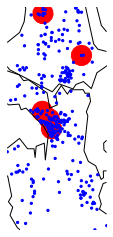

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
from shapely.geometry import MultiPoint

def plot_hotspots(hotspot_xys, client_xys, radius_in_meters):
    hotspot_locations = np.array([untransform_point(*_) for _ in hotspot_xys]) 
    client_locations = np.array([untransform_point(*_) for _ in client_xys])
    llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat = MultiPoint(client_locations).bounds
    m = Basemap(
        llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat, resolution='h', projection='tmerc',
        lon_0=np.mean([llcrnrlon, urcrnrlon]),
        lat_0=np.mean([llcrnrlat, urcrnrlat]))
    m.drawcoastlines()
    radius_in_degrees = get_distance_in_degrees(client_xys[0], radius_in_meters)
    for hotspot_location in hotspot_locations:
        m.tissot(*hotspot_location, radius_deg=radius_in_degrees, npts=15, color='r')
    m.scatter(client_locations[:, 0], client_locations[:, 1],
        color='b', latlon=True, marker='.', zorder=10)
    plt.axis('off')

hotspots_via_random = seattle_fire_response_xys[:5]
plot_hotspots(hotspots_via_random, seattle_fire_response_xys, radius_in_meters)

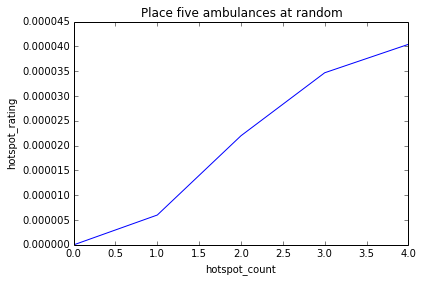

In [8]:
def plot_rating_vs_count(title, hotspot_xys):
    hotspot_counts = xrange(len(hotspot_xys))
    hotspot_ratings = []
    for hotspot_count in hotspot_counts:
        hotspot_ratings.append(rate_hotspots(
            hotspot_xys[:hotspot_count], seattle_fire_response_xys, radius_in_meters))
    plt.plot(hotspot_counts, hotspot_ratings)
    plt.xlabel('hotspot_count')
    plt.ylabel('hotspot_rating')
    plt.title(title)
    return hotspot_ratings

hotspots_via_random_ratings = plot_rating_vs_count(
    'Place five ambulances at random', hotspots_via_random)

# Place one ambulance

In [9]:
import numpy as np

def place_hotspot_via_mean(xys):
    return np.mean(xys, axis=0)

place_hotspot_via_mean(seattle_fire_response_xys)

array([ 387649.22387623,   70446.07270113])

In [10]:
from scipy.optimize import fmin_bfgs
from scipy.spatial.distance import euclidean

def sum_distances_from_hotspot(hotspot_xy, client_xys):
    return sum(euclidean(hotspot_xy, _) for _ in client_xys)

def price_hotspot_via_distance(hotspot_xy, client_xys):
    summed_distance = sum_distances_from_hotspot(hotspot_xy, client_xys)
    return summed_distance

def place_hotspot_via_bfgs(xys):
    return fmin_bfgs(price_hotspot_via_distance, xys[0], args=(xys,), disp=0)

def place_and_price_hotspot(
        client_xys, place_hotspot, price_hotspot=price_hotspot_via_distance):
    hotspot_xy = place_hotspot(client_xys)
    return price_hotspot(hotspot_xy, client_xys)

print place_and_price_hotspot(seattle_fire_response_xys, place_hotspot_via_mean)
print place_and_price_hotspot(seattle_fire_response_xys, place_hotspot_via_bfgs)

1750875.42005
1717521.55375


In [11]:
def price_hotspot_via_distance_over_count(hotspot_xy, client_xys):
    summed_distance = sum_distances_from_hotspot(hotspot_xy, client_xys)
    client_count = len(client_xys)
    return summed_distance / float(client_count)

print place_and_price_hotspot(
    seattle_fire_response_xys, place_hotspot_via_mean, price_hotspot_via_distance_over_count)
print place_and_price_hotspot(
    seattle_fire_response_xys, place_hotspot_via_bfgs, price_hotspot_via_distance_over_count)

5273.72114473
5173.25769203


0.000017


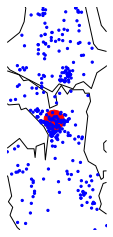

In [12]:
hotspots_via_single = hotspot_xys = [place_hotspot_via_bfgs(seattle_fire_response_xys)]
plot_hotspots(hotspot_xys, seattle_fire_response_xys, radius_in_meters)
print '%f' % rate_hotspots(hotspot_xys, seattle_fire_response_xys, radius_in_meters)

# Place ambulances via split

In [13]:
from itertools import combinations
from scipy.spatial.distance import euclidean

def get_diameter(xys):
    diameter = 0
    for xy1, xy2 in combinations(xys, 2):
        distance = euclidean(xy1, xy2)
        if distance > diameter:
            diameter = distance
    return diameter

get_diameter(seattle_fire_response_xys)

26657.061209676896

In [14]:
from sklearn.cluster import KMeans

def split_group(xys, split_count=2):
    model = KMeans(n_clusters=split_count, n_jobs=split_count)
    model.fit(xys)
    return [xys[model.labels_ == _] for _ in xrange(split_count)]

len(split_group(seattle_fire_response_xys))

2

hotspot_count = 63
hotspot_rating = 0.00237770844044


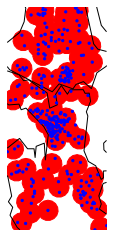

In [15]:
import numpy as np

def yield_hotspot_via_split(xys, radius_in_meters):
    diameter_in_meters = radius_in_meters * 2
    groups = [xys]
    hotspot_packs = []
    while groups:
        group = groups.pop(0)
        if get_diameter(group) > diameter_in_meters:
            groups.extend(split_group(group))
            continue    
        hotspot_xy = place_hotspot_via_mean(group)
        hotspot_price = price_hotspot_via_distance_over_count(hotspot_xy, group)
        hotspot_packs.append((hotspot_price, hotspot_xy))
    for hotspot_price, hotspot_xy in sorted(hotspot_packs, key=lambda x: x[0]):
        yield hotspot_xy
        
hotspots_via_split = hotspot_xys = list(yield_hotspot_via_split(
    seattle_fire_response_xys, radius_in_meters))
print 'hotspot_count = %s' % len(hotspot_xys)
print 'hotspot_rating = %s' % rate_hotspots(
    hotspot_xys, seattle_fire_response_xys, radius_in_meters)
plot_hotspots(hotspot_xys, seattle_fire_response_xys, radius_in_meters)

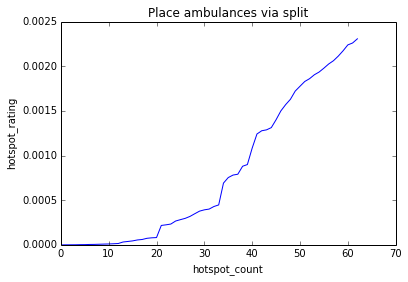

In [16]:
hotspots_via_split_ratings = plot_rating_vs_count(
    'Place ambulances via split', hotspots_via_split)

# Place ambulances via rank

hotspot_count = 102
hotspot_rating = 0.0039797274519


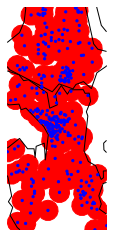

In [17]:
def yield_hotspot_via_rank(xys, radius_in_meters):
    pending_indices = np.arange(len(xys))
    while len(pending_indices):
        pending_xys = xys[pending_indices]        
        pending_tree = KDTree(pending_xys)        
        least_hotspot_price, least_hotspot_xy, least_indices = np.inf, None, []
        for pending_index in pending_indices:
            xy = xys[pending_index]
            # Get events within radius
            selected_distances, selected_indices = pending_tree.query(
                xy, maximum_distance=radius_in_meters)
            selected_xys = pending_xys[selected_indices]
            # Price hotspot
            hotspot_price = price_hotspot_via_distance_over_count(xy, selected_xys)
            if hotspot_price > least_hotspot_price:
                continue
            least_hotspot_price = hotspot_price
            least_hotspot_xy = xy
            least_indices = pending_indices[selected_indices]
        yield least_hotspot_xy
        pending_indices = np.array(list(set(pending_indices) - set(least_indices)))

hotspots_via_rank = hotspot_xys = list(yield_hotspot_via_rank(
    seattle_fire_response_xys, radius_in_meters))
print 'hotspot_count = %s' % len(hotspot_xys)
print 'hotspot_rating = %s' % rate_hotspots(
    hotspot_xys, seattle_fire_response_xys, radius_in_meters)
plot_hotspots(hotspot_xys, seattle_fire_response_xys, radius_in_meters)

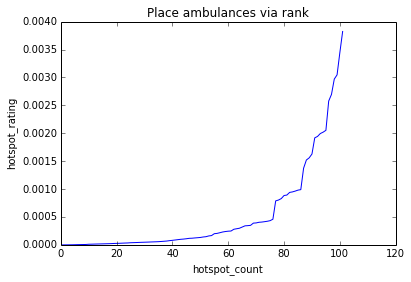

In [18]:
hotspots_via_rank_ratings = plot_rating_vs_count(
    'Place ambulances via rank', hotspots_via_rank)

# Compare

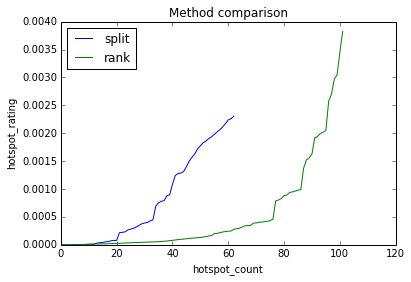

In [19]:
technique_packs = [
    ('split', hotspots_via_split_ratings),
    ('rank', hotspots_via_rank_ratings),
]
hotspot_counts = range(max(len(_[1]) for _ in technique_packs))
for technique_name, technique_ratings in technique_packs:
    plt.plot(
        hotspot_counts[:len(technique_ratings)], technique_ratings, label=technique_name)
plt.xlabel('hotspot_count')
plt.ylabel('hotspot_rating')
plt.title('Method comparison')
plt.legend(loc='upper left');